In [1]:
#!/home/was966/micromamba/envs/responder/bin/python
#sbatch --mem 64G -c 4 -t 12:00:00 -p gpu_quad --gres=gpu:rtx8000:1 ./xxx.py

import sys

sys.path.insert(0, '/home/was966/Research/mims-conceptor/')
from conceptor.utils import plot_embed_with_label
from conceptor import PreTrainer, FineTuner, loadconceptor #, get_minmal_epoch
from conceptor.utils import plot_embed_with_label, score
from conceptor.tokenizer import CANCER_CODE

import os
from tqdm import tqdm
from itertools import chain
import pandas as pd
import numpy as np
import random, torch
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style = 'white', font_scale=1.3)
import warnings
warnings.filterwarnings("ignore")

In [2]:
data_path = './'
itrp_df_label = pd.read_pickle(os.path.join(data_path, 'ITRP.PATIENT.TABLE'))
itrp_df_tpm = pd.read_pickle(os.path.join(data_path, 'ITRP.TPM.TABLE'))
itrp_df_tpm.shape, itrp_df_label.shape

((1133, 15672), (1133, 111))

## 00. Data stractified by antibody targets
same cancer type, same sequencer, different antibodies

In [3]:
itrp_df_label.groupby(['cancer_type', 'sequencer', 'ICI_map']).size().unstack()[['Atezo', 'Ipi', 'Nivo', 'Pembro']]

ICI_map                     Atezo   Ipi  Nivo  Pembro
cancer_type sequencer                                
BLCA        HiSeq2500       298.0   NaN   NaN     NaN
            HiSeq4000        21.0   NaN   NaN     NaN
            NovaSeq6000      35.0   NaN   5.0    46.0
GBM         HiSeq2000         NaN   NaN  20.0     5.0
KIRC        HiSeq2000         2.0   NaN  21.0     NaN
            HiSeq2500       165.0   NaN   6.0     NaN
LUAD        HiSeq2500         5.0   NaN  49.0    33.0
LUSC        HiSeq2500         1.0   NaN  14.0    10.0
SKCM        HiSeq2000         NaN   NaN   NaN    26.0
            HiSeq2000/2500    NaN   NaN  51.0     NaN
            HiSeq2500         NaN  39.0  54.0    94.0
STAD        HiSeq2500         NaN   NaN   NaN    45.0

In [4]:
## group 1
cancer = ['BLCA']
sequencer = ['NovaSeq6000']
ICI_target = ['PD1', 'PDL1']
group1 = [cancer, sequencer, ICI_target]

## group 2
cancer = ['SKCM']
sequencer = ['HiSeq2500']
ICI_target = ['PD1', 'CTLA4']
group2 = [cancer, sequencer, ICI_target]

## group 3
cancer = ['KIRC']
sequencer = ['HiSeq2500']
ICI_target = ['PD1', 'PDL1']
group3 = [cancer, sequencer, ICI_target]

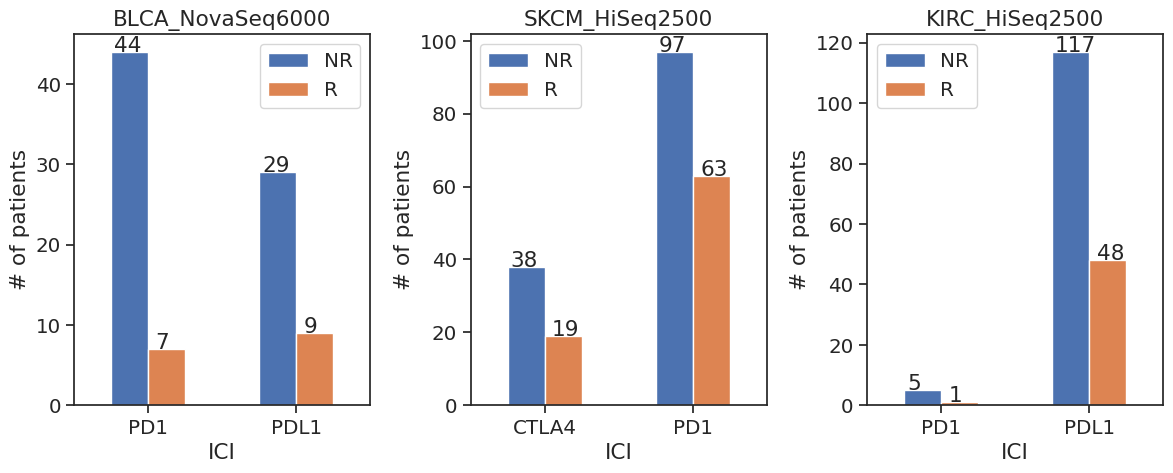

In [5]:
res = []

fig, axes = plt.subplots(figsize=(12, 5), ncols=3)
for group, ax in zip([group1, group2, group3], axes):
    cancer, sequencer, ICI_target  = group
    key = '_'.join(cancer + sequencer)
    sidx = itrp_df_label.cancer_type.isin(cancer) & itrp_df_label.sequencer.isin(sequencer)  & itrp_df_label.ICI_target_map.isin(ICI_target)
    data_used = itrp_df_label[sidx]
    data_used['key'] = key

    bar_data = data_used.groupby(['ICI_target_map', 'response_label']).size().unstack()
    bar_data.plot(kind='bar', ax=ax, legend=False)
    
    for i in range(len(bar_data)):
        b1 = bar_data.iloc[i]
        for v, g in zip(b1, [-0.23, 0.05]):
            ax.text(i+g, v, str(v))

    
    ax.title.set_text(key)
    ax.tick_params(axis='both', which='major', right = False, top=False, direction = 'out',reset = True)
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles, labels, loc='best')
    ax.set_xlabel('ICI')
    ax.set_ylabel('# of patients')
    res.append(data_used)

fig.tight_layout()

## 01. Data stractified by sequencer
same cancer type, same target, different sequencer

In [6]:
itrp_df_label.groupby(['cancer_type', 'ICI_map',  'sequencer', ]).size().unstack()

sequencer               HiSeq2000  HiSeq2000/2500  HiSeq2500  HiSeq4000  \
cancer_type ICI_map                                                       
BLCA        Atezo             NaN             NaN      298.0       21.0   
            Nivo              NaN             NaN        NaN        NaN   
            Other             NaN             NaN        NaN        NaN   
            Pembro            NaN             NaN        NaN        NaN   
GBM         Nivo             20.0             NaN        NaN        NaN   
            Pembro            5.0             NaN        NaN        NaN   
KIRC        Atezo             2.0             NaN      165.0        NaN   
            Ipi+Nivo          4.0             NaN        NaN        NaN   
            Nivo             21.0             NaN        6.0        NaN   
LUAD        Atezo             NaN             NaN        5.0        NaN   
            Ipi+Nivo          NaN             NaN        8.0        NaN   
            Nivo              NaN             NaN       49.0        NaN   
            Other             NaN             NaN        7.0        NaN   
            Pembro            NaN             NaN       33.0        NaN   
LUSC        Atezo             NaN             NaN        1.0        NaN   
            Nivo              NaN             NaN       14.0        NaN   
            Pembro            NaN             NaN       10.0        NaN   
SKCM        Ipi               NaN             NaN       39.0        NaN   
            Ipi+Nivo          NaN             NaN        7.0        NaN   
            Ipi+Pembro        NaN             NaN       25.0        NaN   
            Nivo              NaN            51.0       54.0        NaN   
            Pembro           26.0             NaN       94.0        NaN   
            Uknow             NaN             NaN       34.0        NaN   
STAD        Pembro            NaN             NaN       45.0        NaN   

sequencer               NovaSeq6000  
cancer_type ICI_map                  
BLCA        Atezo              35.0  
            Nivo                5.0  
            Other               3.0  
            Pembro             46.0  
GBM         Nivo                NaN  
            Pembro              NaN  
KIRC        Atezo               NaN  
            Ipi+Nivo            NaN  
            Nivo                NaN  
LUAD        Atezo               NaN  
            Ipi+Nivo            NaN  
            Nivo                NaN  
            Other               NaN  
            Pembro              NaN  
LUSC        Atezo               NaN  
            Nivo                NaN  
            Pembro              NaN  
SKCM        Ipi                 NaN  
            Ipi+Nivo            NaN  
            Ipi+Pembro          NaN  
            Nivo                NaN  
            Pembro              NaN  
            Uknow               NaN  
STAD        Pembro              NaN

In [7]:
itrp_df_label.groupby(['cancer_type', 'ICI_target_map',  'sequencer', ]).size().unstack()

sequencer                   HiSeq2000  HiSeq2000/2500  HiSeq2500  HiSeq4000  \
cancer_type ICI_target_map                                                    
BLCA        PD1                   NaN             NaN        NaN        NaN   
            PDL1                  NaN             NaN      298.0       21.0   
GBM         PD1                  25.0             NaN        NaN        NaN   
KIRC        PD1                  21.0             NaN        6.0        NaN   
            PD1+CTLA4             4.0             NaN        NaN        NaN   
            PDL1                  2.0             NaN      165.0        NaN   
LUAD        Other                 NaN             NaN        6.0        NaN   
            PD1                   NaN             NaN       82.0        NaN   
            PD1+CTLA4             NaN             NaN        8.0        NaN   
            PDL1                  NaN             NaN        6.0        NaN   
LUSC        PD1                   NaN             NaN       24.0        NaN   
            PDL1                  NaN             NaN        1.0        NaN   
SKCM        CTLA4                 NaN             NaN       57.0        NaN   
            Other                 NaN             NaN        2.0        NaN   
            PD1                  26.0            51.0      160.0        NaN   
            PD1+CTLA4             NaN             NaN       34.0        NaN   
STAD        PD1                   NaN             NaN       45.0        NaN   

sequencer                   NovaSeq6000  
cancer_type ICI_target_map               
BLCA        PD1                    51.0  
            PDL1                   38.0  
GBM         PD1                     NaN  
KIRC        PD1                     NaN  
            PD1+CTLA4               NaN  
            PDL1                    NaN  
LUAD        Other                   NaN  
            PD1                     NaN  
            PD1+CTLA4               NaN  
            PDL1                    NaN  
LUSC        PD1                     NaN  
            PDL1                    NaN  
SKCM        CTLA4                   NaN  
            Other                   NaN  
            PD1                     NaN  
            PD1+CTLA4               NaN  
STAD        PD1                     NaN

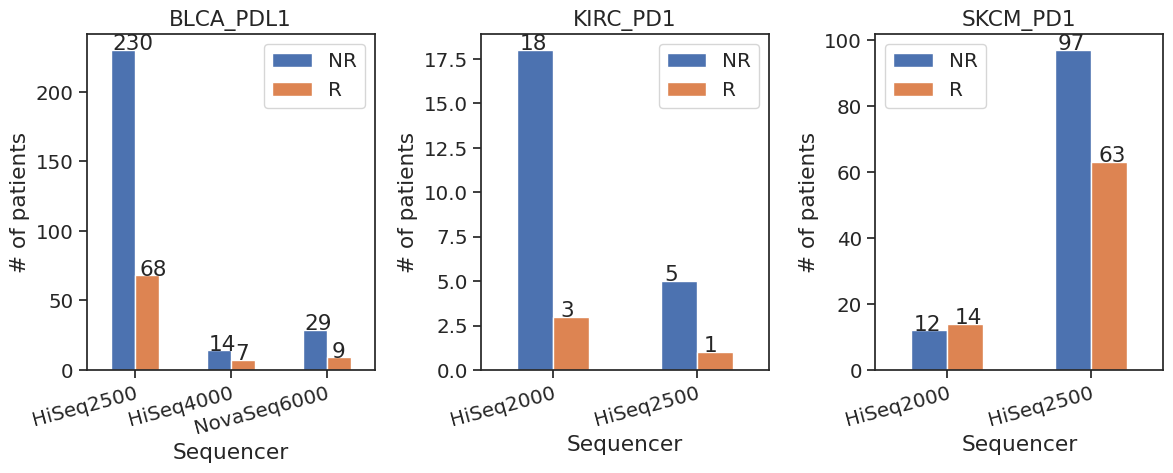

In [8]:
## group 1
cancer = ['BLCA',]
sequencer = ['HiSeq2500',  'HiSeq4000', 'NovaSeq6000']
ICI_target = ['PDL1']
group1 = [cancer, sequencer, ICI_target]


## group 2
cancer = ['KIRC']
sequencer = ['HiSeq2000', 'HiSeq2500']
ICI_target = ['PD1']
group2 = [cancer, sequencer, ICI_target]


## group 2
cancer = ['SKCM']
sequencer = ['HiSeq2000', 'HiSeq2500']
ICI_target = ['PD1']
group3 = [cancer, sequencer, ICI_target]



res = []
fig, axes = plt.subplots(figsize=(12, 5), ncols=3)
for group, ax in zip([group1, group2, group3], axes):
    cancer, sequencer, ICI_target  = group
    key = '_'.join(cancer + ICI_target)
    sidx = itrp_df_label.cancer_type.isin(cancer) & itrp_df_label.sequencer.isin(sequencer)  & itrp_df_label.ICI_target_map.isin(ICI_target)
    data_used = itrp_df_label[sidx]
    data_used['key'] = key

    bar_data = data_used.groupby(['sequencer', 'response_label']).size().unstack()
    bar_data.plot(kind='bar', ax=ax, legend=False)
    
    for i in range(len(bar_data)):
        b1 = bar_data.iloc[i] #.astype(int)
        for v, g in zip(b1, [-0.23, 0.05]):
            ax.text(i+g, v, str(v))

    
    ax.title.set_text(key)
    ax.tick_params(axis='both', which='major', right = False, top=False, direction = 'out',reset = True)
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles, labels, loc='best')
    ax.set_xlabel('Sequencer')
    ax.set_ylabel('# of patients')
    res.append(data_used)
    
    ax.set_xticklabels(
        sequencer, 
        rotation=15, 
        ha="right",  
        rotation_mode="anchor")  # <====== HERE is the ke

fig.tight_layout()

## 02. Data stractified by cancer_type
same target, same sequencer, different cancer_type

In [9]:
itrp_df_label.groupby(['ICI_map', 'sequencer', 'cancer_type']).size().unstack()

cancer_type                 BLCA   GBM   KIRC  LUAD  LUSC  SKCM  STAD
ICI_map    sequencer                                                 
Atezo      HiSeq2000         NaN   NaN    2.0   NaN   NaN   NaN   NaN
           HiSeq2500       298.0   NaN  165.0   5.0   1.0   NaN   NaN
           HiSeq4000        21.0   NaN    NaN   NaN   NaN   NaN   NaN
           NovaSeq6000      35.0   NaN    NaN   NaN   NaN   NaN   NaN
Ipi        HiSeq2500         NaN   NaN    NaN   NaN   NaN  39.0   NaN
Ipi+Nivo   HiSeq2000         NaN   NaN    4.0   NaN   NaN   NaN   NaN
           HiSeq2500         NaN   NaN    NaN   8.0   NaN   7.0   NaN
Ipi+Pembro HiSeq2500         NaN   NaN    NaN   NaN   NaN  25.0   NaN
Nivo       HiSeq2000         NaN  20.0   21.0   NaN   NaN   NaN   NaN
           HiSeq2000/2500    NaN   NaN    NaN   NaN   NaN  51.0   NaN
           HiSeq2500         NaN   NaN    6.0  49.0  14.0  54.0   NaN
           NovaSeq6000       5.0   NaN    NaN   NaN   NaN   NaN   NaN
Other      HiSeq2500         NaN   NaN    NaN   7.0   NaN   NaN   NaN
           NovaSeq6000       3.0   NaN    NaN   NaN   NaN   NaN   NaN
Pembro     HiSeq2000         NaN   5.0    NaN   NaN   NaN  26.0   NaN
           HiSeq2500         NaN   NaN    NaN  33.0  10.0  94.0  45.0
           NovaSeq6000      46.0   NaN    NaN   NaN   NaN   NaN   NaN
Uknow      HiSeq2500         NaN   NaN    NaN   NaN   NaN  34.0   NaN

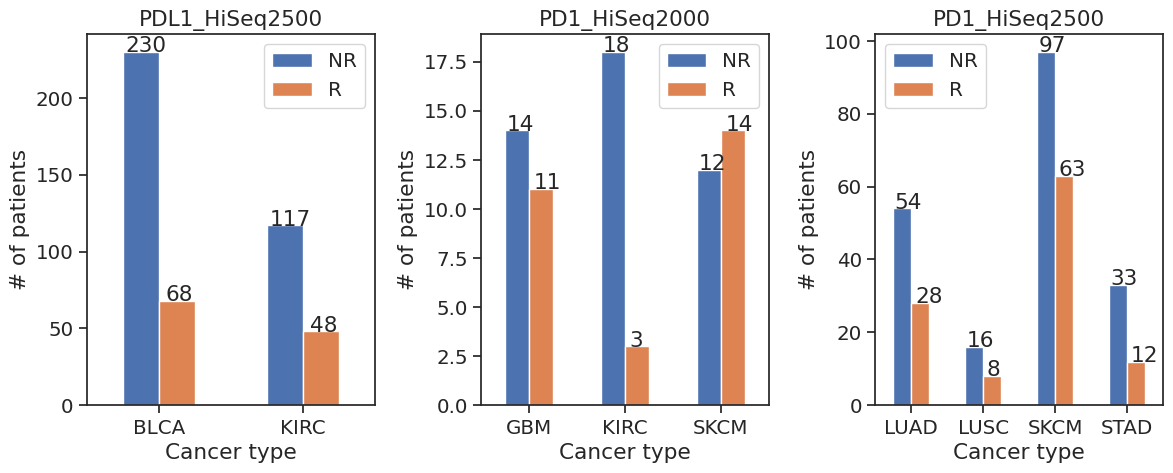

In [10]:
## group 1
cancer = ['BLCA', 'KIRC']
sequencer = ['HiSeq2500']
ICI_target = ['PDL1']
group1 = [cancer, sequencer, ICI_target]

## group 2
cancer = ['GBM', 'KIRC', 'SKCM']
sequencer = ['HiSeq2000']
ICI_target = ['PD1']
group2 = [cancer, sequencer, ICI_target]

## group 3
cancer = ['LUAD', 'LUSC', 'SKCM', 'STAD']
sequencer = ['HiSeq2500']
ICI_target = ['PD1']
group3 = [cancer, sequencer, ICI_target]



res = []
fig, axes = plt.subplots(figsize=(12, 5), ncols=3)
for group, ax in zip([group1, group2, group3], axes):
    cancer, sequencer, ICI_target  = group
    key = '_'.join(ICI_target + sequencer)
    sidx = itrp_df_label.cancer_type.isin(cancer) & itrp_df_label.sequencer.isin(sequencer)  & itrp_df_label.ICI_target_map.isin(ICI_target)
    data_used = itrp_df_label[sidx]
    data_used['key'] = key

    bar_data = data_used.groupby(['cancer_type', 'response_label']).size().unstack()
    bar_data.plot(kind='bar', ax=ax, legend=False)
    
    for i in range(len(bar_data)):
        b1 = bar_data.iloc[i] #.astype(int)
        for v, g in zip(b1, [-0.23, 0.05]):
            ax.text(i+g, v, str(v))

    ax.title.set_text(key)
    ax.tick_params(axis='both', which='major', right = False, top=False, direction = 'out',reset = True)
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles, labels, loc='best')
    ax.set_xlabel('Cancer type')
    ax.set_ylabel('# of patients')
    res.append(data_used)

fig.tight_layout()

## 02. Data stractified by cohort
same cancer, same target, same sequencer, different cohort

In [11]:
x = itrp_df_label.groupby(['cancer_type', 'ICI_target_map', 'sequencer', 'cohort']).size().unstack()
x.loc[(~x.isna()).sum(axis=1)[(~x.isna()).sum(axis=1) > 1].index]

cohort                                Allen  Choueiri  Gide  Hugo  IMVigor210  \
cancer_type ICI_target_map sequencer                                            
KIRC        PD1            HiSeq2000    NaN      10.0   NaN   NaN         NaN   
SKCM        CTLA4          HiSeq2500   39.0       NaN   NaN   NaN         NaN   
            PD1            HiSeq2500    NaN       NaN  41.0   NaN         NaN   
            PD1+CTLA4      HiSeq2500    NaN       NaN  32.0   NaN         NaN   

cohort                                IMmotion150  Kim    Liu   MGH  Miao  \
cancer_type ICI_target_map sequencer                                        
KIRC        PD1            HiSeq2000          NaN  NaN    NaN   NaN  11.0   
SKCM        CTLA4          HiSeq2500          NaN  NaN    NaN  18.0   NaN   
            PD1            HiSeq2500          NaN  NaN  107.0  12.0   NaN   
            PD1+CTLA4      HiSeq2500          NaN  NaN    NaN   2.0   NaN   

cohort                                Riaz  Rose  SU2CLC1  SU2CLC2  Snyder  \
cancer_type ICI_target_map sequencer                                         
KIRC        PD1            HiSeq2000   NaN   NaN      NaN      NaN     NaN   
SKCM        CTLA4          HiSeq2500   NaN   NaN      NaN      NaN     NaN   
            PD1            HiSeq2500   NaN   NaN      NaN      NaN     NaN   
            PD1+CTLA4      HiSeq2500   NaN   NaN      NaN      NaN     NaN   

cohort                                Zhao  
cancer_type ICI_target_map sequencer        
KIRC        PD1            HiSeq2000   NaN  
SKCM        CTLA4          HiSeq2500   NaN  
            PD1            HiSeq2500   NaN  
            PD1+CTLA4      HiSeq2500   NaN

In [12]:
x = itrp_df_label.groupby(['cancer_type', 'ICI', 'sequencer', 'cohort']).size().unstack()
x.loc[(~x.isna()).sum(axis=1)[(~x.isna()).sum(axis=1) > 1].index]

cohort                               Allen  Choueiri  Gide  Hugo  IMVigor210  \
cancer_type ICI           sequencer                                            
KIRC        Nivolumab     HiSeq2000    NaN      10.0   NaN   NaN         NaN   
SKCM        Nivolumab     HiSeq2500    NaN       NaN   9.0   NaN         NaN   
            Pembrolizumab HiSeq2500    NaN       NaN  32.0   NaN         NaN   

cohort                               IMmotion150  Kim   Liu  MGH  Miao  Riaz  \
cancer_type ICI           sequencer                                            
KIRC        Nivolumab     HiSeq2000          NaN  NaN   NaN  NaN  11.0   NaN   
SKCM        Nivolumab     HiSeq2500          NaN  NaN  45.0  NaN   NaN   NaN   
            Pembrolizumab HiSeq2500          NaN  NaN  62.0  NaN   NaN   NaN   

cohort                               Rose  SU2CLC1  SU2CLC2  Snyder  Zhao  
cancer_type ICI           sequencer                                        
KIRC        Nivolumab     HiSeq2000   NaN      NaN      NaN     NaN   NaN  
SKCM        Nivolumab     HiSeq2500   NaN      NaN      NaN     NaN   NaN  
            Pembrolizumab HiSeq2500   NaN      NaN      NaN     NaN   NaN